### Movie Recommendation Engine Development (Spark, Python, SQL)
Use an Alternating Least Squares (ALS) algorithm with Spark APIs to predict the ratings for the movies in [MovieLens dataset](https://grouplens.org/datasets/movielens/latest/)

In [2]:
from csv import reader
from pyspark.sql import Row 
from pyspark.sql import SparkSession
from pyspark.sql import functions as func
from pyspark.sql.window import Window as wd
from pyspark.sql.types import *
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import warnings

import os
os.environ["PYSPARK_PYTHON"] = "python3"

## Part1: Data ETL and Data Exploration

In [4]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("moive analysis") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [5]:
movies = spark.read.load("/FileStore/tables/movies_small.csv", format='csv', header = True)
ratings = spark.read.load("/FileStore/tables/ratings_small.csv", format='csv', header = True)
links = spark.read.load("/FileStore/tables/links_small.csv", format='csv', header = True)
tags = spark.read.load("/FileStore/tables/tags_small.csv", format='csv', header = True)

In [6]:
print (movies.count(), ratings.count())

9742 100836

In [7]:
display(movies.head(5))

movieId,title,genres
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


In [8]:
display(ratings.head(5))

userId,movieId,rating,timestamp
1,1,4.0,964982703
1,3,4.0,964981247
1,6,4.0,964982224
1,47,5.0,964983815
1,50,5.0,964982931


In [9]:
tmp1 = ratings.groupBy("userID").count().toPandas()['count'].min()
tmp2 = ratings.groupBy("movieId").count().toPandas()['count'].min()
print('For the users that rated movies and the movies that were rated:')
print('Minimum number of ratings per user is {}'.format(tmp1))
print('Minimum number of ratings per movie is {}'.format(tmp2))

For the users that rated movies and the movies that were rated:
Minimum number of ratings per user is 20
Minimum number of ratings per movie is 1

In [10]:
tmp1 = sum(ratings.groupBy("movieId").count().toPandas()['count'] == 1)
tmp2 = ratings.select('movieId').distinct().count()
print('{} out of {} movies are rated by only one user'.format(tmp1, tmp2))

3446 out of 9724 movies are rated by only one user

In [11]:
# Check missing value
movies.select([func.count(func.when(func.isnan(c) | func.col(c).isNull() | (func.col(c) == ''), c)).alias(c) for c in movies.columns]).show()

+-------+-----+------+
movieId|title|genres|
+-------+-----+------+
 0| 0| 0|
+-------+-----+------+

In [12]:
ratings.select([func.count(func.when(func.isnan(c) | func.col(c).isNull() | (func.col(c) == ''), c)).alias(c) for c in ratings.columns]).show()

+------+-------+------+---------+
userId|movieId|rating|timestamp|
+------+-------+------+---------+
 0| 0| 0| 0|
+------+-------+------+---------+

In [13]:
links.select([func.count(func.when(func.isnan(c) | func.col(c).isNull() | (func.col(c) == ''), c)).alias(c) for c in links.columns]).show()

+-------+------+------+
movieId|imdbId|tmdbId|
+-------+------+------+
 0| 0| 8|
+-------+------+------+

In [14]:
tags.select([func.count(func.when(func.isnan(c) | func.col(c).isNull() | (func.col(c) == ''), c)).alias(c) for c in tags.columns]).show()

+------+-------+---+---------+
userId|movieId|tag|timestamp|
+------+-------+---+---------+
 0| 0| 0| 0|
+------+-------+---+---------+

## Part 1: Spark SQL and OLAP

### 1. The number of Users

In [17]:
q1 = ratings.select('userID').distinct().count()
print ('The number of users is {}'.format(q1))

The number of users is 283228

### 2. The number of Movies

In [19]:
numberofmovieId = movies.select('movieId').distinct().count()
numberoftitle = movies.select('title').distinct().count()
print (numberofmovieId,numberoftitle)

9742 9737

The number of distinct movieId is different from the number of distinct title. So I find the dumplicate movieIds in same title.

In [21]:
tmp1 = movies.groupBy('title')\
                  .agg(func.collect_list('movieId'))
duplicate = tmp1.where(func.size(tmp1['collect_list(movieId)']) > 1)
display(duplicate)

title,collect_list(movieId)
Eros (2004),"List(32600, 147002)"
Confessions of a Dangerous Mind (2002),"List(6003, 144606)"
Emma (1996),"List(838, 26958)"
Saturn 3 (1980),"List(2851, 168358)"
War of the Worlds (2005),"List(34048, 64997)"


From the dataframe above, we can see there are five titles have duplicate movieId. So the number of movies is 9737.

In [23]:
# Drop the duplicate movie title
new_movies = movies.orderBy('movieId').dropDuplicates(['title'])
# display(new_movies.where(new_movies['movieId']==128862))
print (new_movies.count())

9737

In [24]:
# Modify the movieId with same title
duplicate_movieId_list = duplicate.select('collect_list(movieId)').collect()
# print(str(duplicate_movieId_list[0]).split(',')[1])
tmp = ratings
for item in duplicate_movieId_list:
  item_split = str(item).split('\'')
  tmp1 = tmp.withColumn('movieId', func.when((func.col('movieId')!=item_split[3]), func.col('movieId')).otherwise(item_split[1]))
  tmp = tmp1
new_ratings = tmp
display(new_ratings.where(new_ratings['movieId']=='32600'))

userId,movieId,rating,timestamp
318,32600,4.0,1502207152
606,32600,3.5,1171410642


### 3.  How many movies are rated by users? List movies not rated before

In [26]:
# new_ratings = ratings
numberofratedmovies = new_ratings.select('movieId').distinct().count()
print ('There are {} movies rated by users.'.format(numberofratedmovies))

There are 9719 movies rated by users.

In [27]:
new_movies.cache()

Out[18]: DataFrame[movieId: string, title: string, genres: string]

In [28]:
new_ratings.cache()

Out[19]: DataFrame[userId: string, movieId: string, rating: string, timestamp: string]

In [29]:
tmp1 = new_movies.select('movieId')
tmp2 = new_ratings.select('movieId')
q3 = tmp1.subtract(tmp2).orderBy('movieId')
display(q3)
# print (q3.count())

movieId
1076
144606
147002
168358
25855
26085
26958
2939
30892
32160


### 4. List Movie Genres

In [31]:
genres = new_movies.select('genres')
genres.dtypes

Out[21]: [('genres', 'string')]

In [32]:
genres_list = genres.collect()
type(genres_list)

# Use dictionary and list
# genres_dic = {}
# lst = []
# for gen in genres_list:
#   for e in gen[0].split('|'):
#     if e not in genres_dic:
#       genres_dic[e] = 0
#       lst.append(e)
# print (lst)

# Use set 
genres_set = set()
for gen in genres_list:
  for e in gen[0].split('|'):
    genres_set.add(e)
print (genres_set)
print ('There are {} distinct genres in our movie data.'.format(len(genres_set)))

{'(no genres listed)', 'Thriller', 'War', 'Sci-Fi', 'Children', 'Documentary', 'Musical', 'Adventure', 'Comedy', 'Horror', 'Crime', 'Animation', 'Western', 'Fantasy', 'Action', 'Mystery', 'Drama', 'IMAX', 'Romance', 'Film-Noir'}
There are 20 distinct genres in our movie data.

### 5. Movie for Each Category

In [34]:
split_category = new_movies.withColumn('genres', func.explode(func.split('genres', '\|')))
display(split_category)

movieId,title,genres
112138,22 Jump Street (2014),Action
112138,22 Jump Street (2014),Comedy
112138,22 Jump Street (2014),Crime
3153,"7th Voyage of Sinbad, The (1958)",Action
3153,"7th Voyage of Sinbad, The (1958)",Adventure
3153,"7th Voyage of Sinbad, The (1958)",Fantasy
6671,"Angel at My Table, An (1990)",Drama
1230,Annie Hall (1977),Comedy
1230,Annie Hall (1977),Romance
4021,Before Night Falls (2000),Drama


In [35]:
q5 = split_category.groupBy('genres').agg(func.collect_list('title'))
display(q5)

genres collect_list(title) Crime List(22 Jump Street (2014), Heavenly Creatures (1994), Man Bites Dog (C'est arrivé près de chez vous) (1992), O Brother, Where Art Thou? (2000), One False Move (1992), Psycho (1960), Catwoman (2004), Despicable Me (2010), Dick Tracy (1990), Gomorrah (Gomorra) (2008), Grindhouse (2007), Italian Job, The (1969), Shepherd: Border Patrol, The (2008), Sherlock - A Study in Pink (2010), City of Lost Souls, The (Hyôryuu-gai) (2000), FearDotCom (a.k.a. Fear.com) (a.k.a. Fear Dot Com) (2002), Juice (1992), Masterminds (2016), Sentinel, The (2006), Dead Man's Shoes (2004), Freaks (1932), Nothing to Lose (1997), Secret in Their Eyes, The (El secreto de sus ojos) (2009), 48 Hrs. (1982), Above the Rim (1994), Beavis and Butt-Head Do America (1996), Get Hard (2015), Grifters, The (1990), How to Steal a Million (1966), Mesrine: Public Enemy #1 (L'ennemi public n°1) (2008), New Jersey Drive (1995), Serpico (1973), Bag Man, The (2014), Harry Brown (2009), Maria Full of Grace (Maria, Llena eres de gracia) (2004), Rescuers, The (1977), Cassandra's Dream (2007), Day of the Jackal, The (1973), K-9 (1989), Miss Congeniality (2000), Stendhal Syndrome, The (Sindrome di Stendhal, La) (1996), Teddy Bear (Mis) (1981), Unleashed (Danny the Dog) (2005), District 13 (Banlieue 13) (2004), Dog Day Afternoon (1975), Knock Knock (2015), Take the Money and Run (1969), The Infiltrator (2016), Villain (1971), Blitz (2011), Bugsy (1991), Ghost Dog: The Way of the Samurai (1999), John Wick: Chapter Two (2017), Call Northside 777 (1948), The Commuter (2018), Game Night (2018), Investigation of a Citizen Above Suspicion (Indagine su un cittadino al di sopra di ogni sospetto) (1970), Man on Fire (2004), Marathon Man (1976), Savages (2012), Suicide Squad (2016), The Brain (1969), Three Billboards Outside Ebbing, Missouri (2017), Dampfnudelblues (2013), Man Who Wasn't There, The (2001), Silver Streak (1976), The Nice Guys (2016), Assassination of Jesse James by the Coward Robert Ford, The (2007), Fast and the Furious, The (2001), Lucky Break (2001), No. 1 Ladies' Detective Agency, The (2008), Sin City: A Dame to Kill For (2014), Before the Devil Knows You're Dead (2007), Deathtrap (1982), Fast & Furious 6 (Fast and the Furious 6, The) (2013), Things to Do in Denver When You're Dead (1995), Wild Horses (2015), Baby Driver (2017), Domino (2005), Frailty (2001), Negotiator, The (1998), Now You See Me (2013), Trou, Le (Hole, The) (Night Watch, The) (1960), Deceiver (1997), F/X2 (a.k.a. F/X 2 - The Deadly Art of Illusion) (1991), Great Mouse Detective, The (1986), Man with the Iron Fists, The (2012), Pride and Glory (2008), Ransom (1996), Wonderland (2003), Bone Man, The (Der Knochenmann) (2009), Fast Five (Fast and the Furious 5, The) (2011), Léon: The Professional (a.k.a. The Professional) (Léon) (1994), Murder at 1600 (1997), The Fate of the Furious (2017), Undercover Blues (1993), Pierrot le fou (1965), Beverly Hills Cop (1984), Bling Ring, The (2013), Blood Work (2002), Cadillac Man (1990), Elite Squad: The Enemy Within (Tropa de Elite 2 - O Inimigo Agora É Outro) (2010), Herod's Law (Ley de Herodes, La) (2000), Mini's First Time (2006), Shaft (1971), Stoning of Soraya M., The (2008), Supercop 2 (Project S) (Chao ji ji hua) (1993), Copycat (1995), Fatal Beauty (1987), General Died at Dawn, The (1936), Man Without a Past, The (Mies vailla menneisyyttä) (2002), Mother (Madeo) (2009), No Country for Old Men (2007), Obsessed (2009), Police Academy 3: Back in Training (1986), Sign of Four, The (1987), Sonatine (Sonachine) (1993), Sorrow (2015), Striking Distance (1993), Gang Related (1997), Irreversible (Irréversible) (2002), Novocaine (2001), Pathology (2008), Shoot 'Em Up (2007), Untouchables, The (1987), Bangkok Dangerous (2008), Corky Romano (2001), Dark Knight, The (2008), Red 2 (2013), Time of the Gypsies (Dom za vesanje) (1989), Trainspotting (1996), Wrong Arm of the Law, The (1963), Jack Reacher (2012), Suspect Zero (2004), Brick (200

In [36]:
q5 = split_category.orderBy('genres')
display(q5)

movieId,title,genres
182727,A Christmas Story Live! (2017),(no genres listed)
171495,Cosmos,(no genres listed)
171891,Generation Iron 2,(no genres listed)
161008,The Forbidden Dance (1990),(no genres listed)
167570,The OA,(no genres listed)
172497,T2 3-D: Battle Across Time (1996),(no genres listed)
156605,Paterson,(no genres listed)
114335,La cravate (1957),(no genres listed)
174403,The Putin Interviews (2017),(no genres listed)
159161,Ali Wong: Baby Cobra (2016),(no genres listed)


The movies with single genres are showing in the dataframe above ordered by the 20 distinct genres. So we can easily find the movies when particular one catogery we need focus on.

In [38]:
# For example
catogery_action = q5.where(q5.genres == 'Action')
display(catogery_action)

movieId,title,genres
5049,48 Hrs. (1982),Action
7193,"Adventures of Ford Fairlane, The (1990)",Action
3593,Battlefield Earth (2000),Action
62999,Madagascar: Escape 2 Africa (2008),Action
48596,"Marine, The (2006)",Action
85354,Mesrine: Public Enemy #1 (L'ennemi public n°1) (2008),Action
4180,Reform School Girls (1986),Action
43928,Ultraviolet (2006),Action
8983,House of Flying Daggers (Shi mian mai fu) (2004),Action
8593,Juice (1992),Action


## Part2: Spark ALS based approach for training model
Use an RDD-based API from pyspark.mllib to predict the ratings

In [40]:
movie_rating = sc.textFile("/FileStore/tables/ratings_small.csv")
header = movie_rating.take(1)[0]
rating_data = movie_rating.filter(lambda line: line!=header).map(lambda line: line.split(",")).map(lambda tokens: (tokens[0],tokens[1],tokens[2])).cache()

In [41]:
# check three rows
rating_data.take(3)

Out[44]: [('1', '1', '4.0'), ('1', '3', '4.0'), ('1', '6', '4.0')]

Now we split the data into training/validation/testing sets using a 6/2/2 ratio.

In [43]:
train, validation, test = rating_data.randomSplit([6,2,2],seed = 50)

In [44]:
train.cache()
train.count()

Out[46]: PythonRDD[444] at RDD at PythonRDD.scala:57

In [45]:
validation.cache()
validation.count()

Out[48]: 20265

In [46]:
test.cache()
test.count()

Out[49]: 20145

### ALS Model Selection and Evaluation

With the ALS model, we can use a grid search to find the optimal hyperparameters.

In [48]:
from pyspark.mllib.recommendation import ALS

def train_ALS(train_data, validation_data, num_iters, reg_param, ranks):
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    testdata = validation_data.map(lambda p: (p[0], p[1]))
    for rank in ranks:
        for reg in reg_param:
            # write your approach to train ALS model
            # Build the recommendation model using ALS on the training data
            model = ALS.train(train_data, rank, iterations=num_iters, lambda_=reg, seed=50)
            # make prediction
            predictions = model.predictAll(testdata).map(lambda r: ((r[0], r[1]), r[2]))
            # get the rating result
            ratesAndPreds = validation_data.map(lambda r: ((int(r[0]), int(r[1])), float(r[2]))).join(predictions)
            # get the RMSE
            rmse = math.sqrt(ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
            print("Root-mean-square error = " + str(rmse))
            error = rmse
            print ('{} latent factors and regularization = {}: validation RMSE is {}'.format(rank, reg, error))
            if error < min_error:
                min_error = error
                best_rank = rank
                best_regularization = reg
                best_model = model
    print ('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
    return best_model

In [49]:
num_iterations = 10
ranks = [6, 8, 10, 12, 14]
reg_params = [0.05, 0.1, 0.2, 0.4, 0.8]

import time
start_time = time.time()
final_model = train_ALS(train, validation, num_iterations, reg_params, ranks)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

Root-mean-square error = 0.9829899827538335
6 latent factors and regularization = 0.05: validation RMSE is 0.9829899827538335
Root-mean-square error = 0.9184732246684029
6 latent factors and regularization = 0.1: validation RMSE is 0.9184732246684029
Root-mean-square error = 0.8955167656336196
6 latent factors and regularization = 0.2: validation RMSE is 0.8955167656336196
Root-mean-square error = 0.9596473160796768
6 latent factors and regularization = 0.4: validation RMSE is 0.9596473160796768
Root-mean-square error = 1.1752097612694055
6 latent factors and regularization = 0.8: validation RMSE is 1.1752097612694055
Root-mean-square error = 1.0028190491729183
8 latent factors and regularization = 0.05: validation RMSE is 1.0028190491729183
Root-mean-square error = 0.9250491009490633
8 latent factors and regularization = 0.1: validation RMSE is 0.9250491009490633
Root-mean-square error = 0.896757488504122
8 latent factors and regularization = 0.2: validation RMSE is 0.896757488504122
Root-mean-square error = 0.9592446408122395
8 latent factors and regularization = 0.4: validation RMSE is 0.9592446408122395
Root-mean-square error = 1.175216501538395
8 latent factors and regularization = 0.8: validation RMSE is 1.175216501538395
Root-mean-square error = 1.00840719289906
10 latent factors and regularization = 0.05: validation RMSE is 1.00840719289906
Root-mean-square error = 0.9243641999965179
10 latent factors and regularization = 0.1: validation RMSE is 0.9243641999965179
Root-mean-square error = 0.8985612216847362
10 latent factors and regularization = 0.2: validation RMSE is 0.8985612216847362
Root-mean-square error = 0.9601679274979407
10 latent factors and regularization = 0.4: validation RMSE is 0.9601679274979407
Root-mean-square error = 1.1752144382127863
10 latent factors and regularization = 0.8: validation RMSE is 1.1752144382127863
Root-mean-square error = 1.0108080124640142
12 latent factors and regularization = 0.05: validation RMSE is 1.0108080124640142
Root-mean-square error = 0.918706116434947
12 latent factors and regularization = 0.1: validation RMSE is 0.918706116434947
Root-mean-square error = 0.8965232291541638
12 latent factors and regularization = 0.2: validation RMSE is 0.8965232291541638
Root-mean-square error = 0.9601722893512575
12 latent factors and regularization = 0.4: validation RMSE is 0.9601722893512575
Root-mean-square error = 1.1752121603322319
12 latent factors and regularization = 0.8: validation RMSE is 1.1752121603322319
Root-mean-square error = 1.0086793236604437
14 latent factors and regularization = 0.05: validation RMSE is 1.0086793236604437
Root-mean-square error = 0.9150005364604105
14 latent factors and regularization = 0.1: validation RMSE is 0.9150005364604105
Root-mean-square error = 0.8940327694491559
14 latent factors and regularization = 0.2: validation RMSE is 0.8940327694491559
Root-mean-square error = 0.959594975963146
14 latent factors and regularization = 0.4: validation RMSE is 0.959594975963146
Root-mean-square error = 1.1752161508684429
14 latent factors and regularization = 0.8: validation RMSE is 1.1752161508684429

The best model has 14 latent factors and regularization = 0.2
Total Runtime: 189.98 seconds

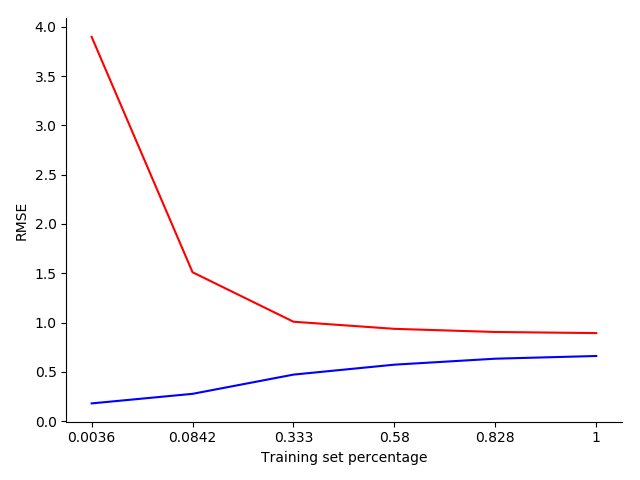

In [50]:
# Tutorial: https://www.dataquest.io/blog/learning-curves-machine-learning/
train_size = [0.0036, 0.0842, 0.333, 0.58, 0.828, 1]
def plot_learning_curve_of_train_size(train_size, train_data, validation_data, reg, rank):
  result_sample = []
  result_test = []
  testdata = validation_data.map(lambda p: (p[0], p[1]))
  for i in train_size: 
    train_sample = train_data.sample(False, i, seed = 50)
    model = ALS.train(train_sample, rank, iterations=10, lambda_=reg, seed=50)
    
    testdata_sample = train_sample.map(lambda p: (p[0], p[1]))
    predictions_sample = model.predictAll(testdata_sample).map(lambda r: ((r[0], r[1]), r[2]))
    ratesAndPreds_sample = train_sample.map(lambda r: ((int(r[0]), int(r[1])), float(r[2]))).join(predictions_sample)
    rmse_sample = math.sqrt(ratesAndPreds_sample.map(lambda r: (r[1][0] - r[1][1])**2).mean())
    result_sample.append(rmse_sample)
    
    predictions = model.predictAll(testdata).map(lambda r: ((r[0], r[1]), r[2]))
    ratesAndPreds = validation_data.map(lambda r: ((int(r[0]), int(r[1])), float(r[2]))).join(predictions)
    rmse = math.sqrt(ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
    result_test.append(rmse)
    
  x = np.arange(1,7,1)
  fig, ax = plt.subplots()
  ax.plot(x, result_sample, color='b', label='Training error')
  ax.plot(x, result_test, color='r', label='Validation error')
  ax.set_ylabel('RMSE')
  ax.set_xlabel('Training set percentage')
  ax.set_xticks(x)
  ax.set_xticklabels(train_size, fontsize='10')
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  plt.tight_layout()
  display(fig)

plot_learning_curve_of_train_size(train_size, train, validation, 0.2, 14)

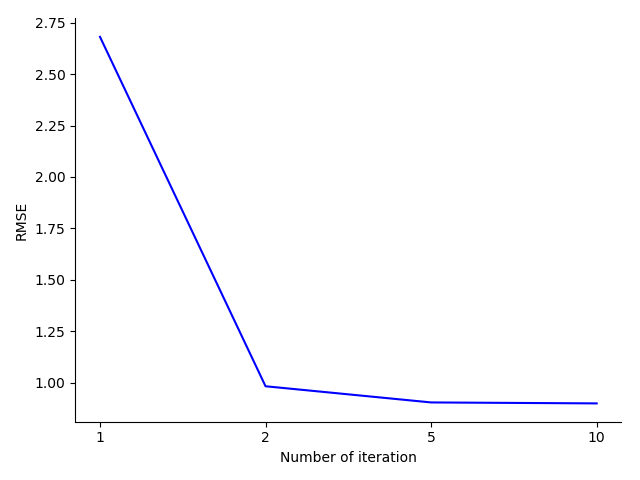

In [51]:
iter_array = [1, 2, 5, 10]
def plot_learning_curve_of_iteration(iter_array, train_data, validation_data, reg, rank):
  result = []
  testdata = validation_data.map(lambda p: (p[0], p[1]))
  for iter in iter_array:
    model = ALS.train(train_data, rank, iterations=iter, lambda_=reg, seed=50)
    predictions = model.predictAll(testdata).map(lambda r: ((r[0], r[1]), r[2]))
    ratesAndPreds = validation_data.map(lambda r: ((int(r[0]), int(r[1])), float(r[2]))).join(predictions)
    rmse = math.sqrt(ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
    result.append(rmse)
    
  x = np.arange(1,5,1)
  fig, ax = plt.subplots()
  ax.plot(x, result, color='b')
  ax.set_ylabel('RMSE')
  ax.set_xlabel('Number of iteration')
  ax.set_xticks(x)
  ax.set_xticklabels(iter_array, fontsize='10')
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  plt.tight_layout()
  display(fig)

plot_learning_curve_of_iteration(iter_array, train, validation, 0.2, 10)

### Model testing on the test data
And finally, wite your code to make a prediction and check the testing error.

In [53]:
testdata = test.map(lambda p: (p[0], p[1]))
# make prediction
predictions = final_model.predictAll(testdata).map(lambda r: ((r[0], r[1]), r[2]))
# get the rating result
ratesAndPreds = test.map(lambda r: ((int(r[0]), int(r[1])), float(r[2]))).join(predictions)
# get the RMSE
rmse = math.sqrt(ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
print("Test error = " + str(rmse))

Test error = 0.8945384624782439